Code to implement and test changes to icesat2 download structure so that it is compliant with the new Harmony backend

In [1]:
import os
import datetime

import geopandas as gpd

from HydroEO.utils import general, geometry

from harmony import BBox, WKT, Client, Collection, Request
from harmony.config import Environment

In [2]:
# load example data
gdf = gpd.read_file(
    r"C:\Users\cwch\Projects\WR-Collaboration\rk-altimetry\notebooks\example_data\example_res.shp"
)
gdf.head()

,project,geometry
0,Nuozhadu,"POLYGON ((100.31926 22.97188, 100.31983 22.971..."


In [3]:
# grab coordinates of geometry
coords = [(x, y) for x, y in gdf.loc[0, "geometry"].envelope.exterior.coords]

# set start and end dates
startdate = datetime.date(*(2019, 1, 1))
enddate = datetime.date(*(2025, 1, 1))

In [4]:
token = os.getenv("EDL_TOKEN")
if token is None or token == "":
    print("Use .netrc for client authentication")
    harmony_client = Client()
else:
    print("Use EDL token from the environment for client authentication")
    harmony_client = Client(token=token)

Use .netrc for client authentication


In [5]:
# query and download data
# print(f"Searching for Icesat2 ATL13 for aoi from {startdate} to {enddate}")
# _ = icesat2.query(
#     aoi=coords,
#     startdate=startdate,
#     enddate=enddate,
#     earthdata_credentials=credentials,
#     download_directory=download_dir,
#     product="ATL13",
# )

# request the
request = Request(
    collection=Collection(id="ATL13"),
    # spatial=BBox(-155.75, 19.26, -155.3, 19.94), # bounding box example that can be used as an alternative to shapefile input
    # spatial=WKT('POLYGON((-155.75 19.26, -155.3 19.26, -155.3 19.94, -155.75 19.94, -155.75 19.26))'), # WKT example
    spatial=WKT(geometry.poly_coord_list_to_wkt(coords)),
    temporal={
        "start": startdate,
        "stop": enddate,
    },
    # variables=["science/grids/data/unwrappedPhase"],
    # format="HDF5",
    # max_results=2,
    # If desired, deliver results to a custom destination bucket. Note the bucket must reside in AWS us-west-2 region.
    # destination_url='s3://my-bucket'
)

In [6]:
request.is_valid()

True

In [7]:
job_id = harmony_client.submit(request)
job_id

'6dce582e-95c3-4b32-bfc6-d808b0b4adb3'

In [8]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing:   0% ] |                                                   | [/]
 [ Processing:   0% ] |                                                   | [-]
 [ Processing:   0% ] |                                                   | [\]
 [ Processing:   0% ] |                                                   | [|]
 [ Processing:   0% ] |                                                   | [/]
 [ Processing:   0% ] |                                                   | [-]
 [ Processing:   0% ] |                                                   | [\]
 [ Processing:   0% ] |                                                   | [|]
 [ Processing:   0% ] |                                                   | [/]
 [ Processing:   9% ] |####                                               | [-]
 [ Processing:   9% ] |####                                               | [\]
 [ Processing:   9% ] |####                                               | [|]
 [ Processing:   9% ] |####             

In [9]:
data = harmony_client.result_json(job_id)
data

{'username': 'connorchewning',
 'status': 'complete_with_errors',
 'message': 'The job has completed with errors. See the errors field for more details',
 'progress': 100,
 'createdAt': '2025-01-22T13:38:03.731Z',
 'updatedAt': '2025-01-22T13:44:13.049Z',
 'dataExpiration': '2025-02-21T13:38:03.731Z',
 'links': [{'title': 'STAC catalog',
   'href': 'https://harmony.earthdata.nasa.gov/stac/6dce582e-95c3-4b32-bfc6-d808b0b4adb3/',
   'rel': 'stac-catalog-json',
   'type': 'application/json'},
  {'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/6dce582e-95c3-4b32-bfc6-d808b0b4adb3/88457237/ATL13_20190122152707_03850201_006_01_subsetted.h5',
   'title': 'ATL13_20190122152707_03850201_006_01_subsetted.h5',
   'type': 'application/x-hdf5',
   'rel': 'data',
   'bbox': [-180, -90, 180, 90],
   'temporal': {'start': '2019-01-22T15:27:07.000Z',
    'end': '2019-01-22T21:44:17.000Z'}},
  {'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-pr

In [10]:
urls = harmony_client.result_urls(job_id, show_progress=True)
urls

<generator object Client.result_urls at 0x000001EE8E643040>

In [11]:
results = harmony_client.download_all(
    job_id,
    directory=r"C:\Users\cwch\Projects\WR-Collaboration\rk-altimetry\data\icesat2\temp",
    overwrite=True,
)
file_names = [f.result() for f in results]
file_names

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\cwch\\Projects\\WR-Collaboration\\rk-altimetry\\data\\icesat2\\temp\\88457237_ATL13_20190122152707_03850201_006_01_subsetted.h5'

C:\Users\cwch\Projects\WR-Collaboration\rk-altimetry\HydroEO\satellites\icesat2.py:5: FutureWarning: icepyx v1.x is being deprecated; the back-end systems on which it relies
will be shut down as of late 2024. At that time, upgrade to icepyx v2.x, which uses the
new NASA Harmony back-end, will be required. Please see
<https://icepyx.readthedocs.io/en/latest/user_guide/changelog/v1.3.0.html> for more
information!

  import icepyx as ipx
c:\Users\cwch\AppData\Local\miniforge3\envs\rk-altimetry\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
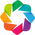

In [18]:
from HydroEO.satellites import icesat2

In [21]:
keys = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
data = icesat2.ATL13(file_names[0], keys[0])
df = data.read()

In [22]:
df

,height,lat,lon,date,wb_type,wb_size,wb_id,dem,sat_frac_track,beam,orbit,rgt,cycle_number,file_name
0,810.752197,23.061030,100.682613,2019-01-22 16:08:28.540875,5,0,2006439,779.990845,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
1,810.719788,23.060960,100.682606,2019-01-22 16:08:28.541975,5,0,2006439,779.990845,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
2,810.740295,23.060896,100.682600,2019-01-22 16:08:28.542975,5,0,2006439,777.682495,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
3,810.717468,23.060832,100.682593,2019-01-22 16:08:28.543975,5,0,2006439,777.682495,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
4,810.753784,23.060761,100.682586,2019-01-22 16:08:28.545075,5,0,2006439,777.682495,0.004926,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,810.746277,23.044657,100.680884,2019-01-22 16:08:28.796875,5,0,2006439,761.262573,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
118,810.790833,23.044451,100.680862,2019-01-22 16:08:28.800075,5,0,2006439,763.617798,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
119,810.725464,23.044182,100.680833,2019-01-22 16:08:28.804275,5,0,2006439,764.927734,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
120,810.750244,23.043787,100.680790,2019-01-22 16:08:28.810475,5,0,2006439,757.717102,0.000000,gt1l,1973,385,2,88411918_ATL13_20190122152707_03850201_006_01_...
